In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Tuple, List, Dict


In [20]:
train_path = './crime_train.csv'
test_path = './crime_test.csv'

if not (os.path.exists(train_path) and os.path.exists(test_path)):
    alt_train = '/mnt/data/crime_train.csv'
    alt_test  = '/mnt/data/crime_test.csv'
    if os.path.exists(alt_train) and os.path.exists(alt_test):
        train_path, test_path = alt_train, alt_test
    else:
        raise FileNotFoundError(
            "Could not find crime_train.csv and crime_test.csv in the current folder or /mnt/data. "
            "Please place them next to this notebook and re-run."
        )

print('Using train:', train_path)
print('Using test :', test_path)

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test  shape:', test_df.shape)

display(train_df.head())
display(test_df.head())

print('\nTarget value counts (train):') 
display(train_df['closed'].value_counts())


Using train: ./crime_train.csv
Using test : ./crime_test.csv
Train shape: (22489, 12)
Test  shape: (9639, 12)


,Unnamed: 0,Num,case_filed,city,area,crime_description,age,sex,weapon,domain,police_department,closed
0,19794,19795,04-04-2022 18:00,Mumbai,307,VEHICLE - STOLEN,63.0,X,Poison,Violent Crime,12.0,No
1,13762,13763,07-27-2021 10:00,Surat,504,ROBBERY,57.0,F,Explosives,Violent Crime,3.0,No
2,30311,30312,06-16-2023 23:00,Thane,493,ASSAULT,33.0,F,Firearm,Violent Crime,18.0,No
3,5043,5044,07-29-2020 03:00,Ahmedabad,169,PUBLIC INTOXICATION,76.0,F,Knife,Other Crime,3.0,No
4,35008,35009,12-29-2023 16:00,Mumbai,133,PUBLIC INTOXICATION,13.0,M,NaN,Other Crime,13.0,No


,Unnamed: 0,Num,case_filed,city,area,crime_description,age,sex,weapon,domain,police_department,closed
0,32079,32080,08-29-2023 15:00,Pune,589,VEHICLE - STOLEN,57.0,M,Explosives,Violent Crime,13.0,Yes
1,39119,39120,06-17-2024 23:00,Ahmedabad,596,HOMICIDE,49.0,F,Other,Other Crime,10.0,Yes
2,34553,34554,12-10-2023 17:00,Mumbai,337,PUBLIC INTOXICATION,41.0,M,Firearm,Other Crime,12.0,Yes
3,29684,29685,05-21-2023 20:00,Hyderabad,252,TRAFFIC VIOLATION,15.0,F,Other,Traffic Fatality,11.0,Yes
4,20673,20674,05-11-2022 09:00,Hyderabad,340,VEHICLE - STOLEN,42.0,F,Other,Violent Crime,18.0,Yes



Target value counts (train):


closed
Yes    11253
No     11236
Name: count, dtype: int64

In [21]:

from collections import defaultdict

def fit_preprocessing(df: pd.DataFrame, categorical_cols: List[str], numeric_cols: List[str]):
    """Fit encoders and scalers on the provided dataframe (train only)."""
    encoders = {}
    for col in categorical_cols:
        levels = sorted(df[col].dropna().unique().tolist())
        encoders[col] = levels
    mean = df[numeric_cols].mean().values
    std = df[numeric_cols].std().values
    std[std == 0] = 1.0
    scalers = {'mean': mean, 'std': std}
    return encoders, scalers

def apply_preprocessing(df: pd.DataFrame, categorical_cols: List[str], numeric_cols: List[str], encoders: Dict, scalers: Dict):
    """Apply fitted encoders and scalers to a dataframe and return X, y arrays."""
    df = df.copy()

    for col in categorical_cols:
        if col not in df.columns:
            df[col] = np.nan
    for col in numeric_cols:
        if col not in df.columns:
            df[col] = 0.0

    oh_cols = []
    for col in categorical_cols:
        levels = encoders[col]
        for lvl in levels:
            colname = f"{col}__{lvl}"
            df[colname] = df[col].fillna('__missing__').astype(str) == str(lvl)
            df[colname] = df[colname].astype(int)
            oh_cols.append(colname)

    df[numeric_cols] = df[numeric_cols].fillna(0.0)
    X_num = (df[numeric_cols].values - scalers['mean']) / scalers['std']

    X = np.hstack([np.ones((len(df),1)), X_num, df[oh_cols].values])

    if 'closed' in df.columns:
        y = df['closed'].map({'Yes':1, 'No':0}).values.astype(float)
    else:
        y = None
    return X, y, {'numeric_cols': numeric_cols, 'oh_cols': oh_cols}


In [22]:

class LogisticRegressionGD:
    def __init__(self, n_features:int, lr: float = 0.01):
        self.lr = lr
        self.W = np.zeros(n_features)
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    def predict_proba(self, X):
        return self.sigmoid(X.dot(self.W))
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    def compute_loss(self, X, y):
        m = len(y)
        p = self.predict_proba(X)
        eps = 1e-9
        p = np.clip(p, eps, 1-eps)
        loss = - (1.0/m) * np.sum(y*np.log(p) + (1-y)*np.log(1-p))
        return loss
    def compute_grad(self, X, y):
        m = len(y)
        p = self.predict_proba(X)
        grad = (1.0/m) * X.T.dot(p - y)
        return grad
    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=100, print_every=10):
        history = {'loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
        for epoch in range(1, epochs+1):
            grad = self.compute_grad(X_train, y_train)
            self.W -= self.lr * grad
            loss = self.compute_loss(X_train, y_train)
            history['loss'].append(loss)
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val)
                history['val_loss'].append(val_loss)
            train_acc = np.mean(self.predict(X_train) == y_train)
            history['train_acc'].append(train_acc)
            if X_val is not None and y_val is not None:
                val_acc = np.mean(self.predict(X_val) == y_val)
                history['val_acc'].append(val_acc)
            if epoch % print_every == 0 or epoch==1 or epoch==epochs:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch:4d} | loss={loss:.4f} | val_loss={val_loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")
                else:
                    print(f"Epoch {epoch:4d} | loss={loss:.4f} | train_acc={train_acc:.4f}")
        return history


In [23]:

def train_logistic_pipeline(train_df: pd.DataFrame, test_df: pd.DataFrame, categorical_cols: List[str], numeric_cols: List[str],
                            epochs=200, lr=0.1, val_split=0.2, retrain_on_full=True):

    df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    val_size = int(len(df) * val_split)
    val_df = df.iloc[:val_size].reset_index(drop=True)
    tr_df = df.iloc[val_size:].reset_index(drop=True)
    print('Train rows:', len(tr_df), 'Val rows:', len(val_df))

    encoders, scalers = fit_preprocessing(tr_df, categorical_cols, numeric_cols)
    X_tr, y_tr, meta = apply_preprocessing(tr_df, categorical_cols, numeric_cols, encoders, scalers)
    X_val, y_val, _ = apply_preprocessing(val_df, categorical_cols, numeric_cols, encoders, scalers)
    X_test, y_test, _ = apply_preprocessing(test_df, categorical_cols, numeric_cols, encoders, scalers)
    print('Feature matrix shapes ->', X_tr.shape, X_val.shape, X_test.shape)

    model = LogisticRegressionGD(n_features=X_tr.shape[1], lr=lr)
    history = model.fit(X_tr, y_tr, X_val, y_val, epochs=epochs, print_every=max(1, epochs//10))

    plt.figure(figsize=(8,5))
    plt.plot(history['loss'], label='train_loss')
    if len(history['val_loss'])>0:
        plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend(); plt.grid(True); plt.show()
    print('\nValidation accuracy (final):', history['val_acc'][-1])

    if retrain_on_full:
        print('Retraining on full crime_train (train+val) for final model...') 
        encoders_full, scalers_full = fit_preprocessing(train_df, categorical_cols, numeric_cols)
        X_full, y_full, _ = apply_preprocessing(train_df, categorical_cols, numeric_cols, encoders_full, scalers_full)
        model_full = LogisticRegressionGD(n_features=X_full.shape[1], lr=lr)
        history_full = model_full.fit(X_full, y_full, epochs=epochs, print_every=max(1, epochs//10))

        X_test_full, y_test_full, _ = apply_preprocessing(test_df, categorical_cols, numeric_cols, encoders_full, scalers_full)
        test_acc = np.mean(model_full.predict(X_test_full) == y_test_full)
        print('\nFINAL TEST ACCURACY:', test_acc)

        preds = model_full.predict(X_test_full)
        out = test_df.copy().reset_index(drop=True)
        out['pred_closed'] = preds
        out['pred_closed_label'] = out['pred_closed'].map({1:'Yes', 0:'No'})
        out[['pred_closed_label']].to_csv('crime_test_predictions.csv', index=False)
        print('Saved crime_test_predictions.csv') 
        return model_full, history_full, encoders_full, scalers_full, test_acc
    else:
        test_acc = np.mean(model.predict(X_test) == y_test)
        print('\nFINAL TEST ACCURACY:', test_acc)
        return model, history, encoders, scalers, test_acc


Columns present in train: ['Unnamed: 0', 'Num', 'case_filed', 'city', 'area', 'crime_description', 'age', 'sex', 'weapon', 'domain', 'police_department', 'closed']
Using categorical: ['city', 'crime_description', 'sex', 'weapon', 'domain']
Using numeric    : ['area', 'age', 'police_department']
Train rows: 17992 Val rows: 4497
Feature matrix shapes -> (17992, 67) (4497, 67) (9639, 67)
Epoch    1 | loss=0.6931 | val_loss=0.6931 | train_acc=0.5082 | val_acc=0.4979
Epoch   20 | loss=0.6930 | val_loss=0.6932 | train_acc=0.5104 | val_acc=0.4954
Epoch   40 | loss=0.6929 | val_loss=0.6932 | train_acc=0.5106 | val_acc=0.4959
Epoch   60 | loss=0.6929 | val_loss=0.6932 | train_acc=0.5132 | val_acc=0.4921
Epoch   80 | loss=0.6928 | val_loss=0.6932 | train_acc=0.5152 | val_acc=0.4950
Epoch  100 | loss=0.6927 | val_loss=0.6933 | train_acc=0.5155 | val_acc=0.4948
Epoch  120 | loss=0.6927 | val_loss=0.6933 | train_acc=0.5170 | val_acc=0.4952
Epoch  140 | loss=0.6927 | val_loss=0.6933 | train_acc=0.51

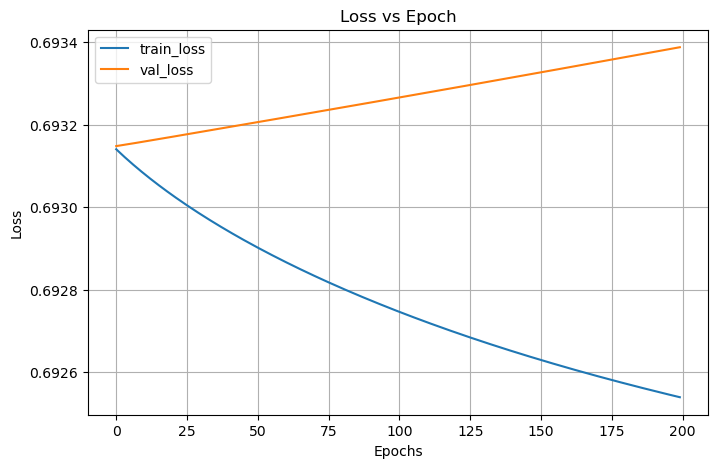


Validation accuracy (final): 0.4965532577273738
Retraining on full crime_train (train+val) for final model...
Epoch    1 | loss=0.6931 | train_acc=0.5102
Epoch   20 | loss=0.6931 | train_acc=0.5103
Epoch   40 | loss=0.6930 | train_acc=0.5117
Epoch   60 | loss=0.6929 | train_acc=0.5118
Epoch   80 | loss=0.6929 | train_acc=0.5113
Epoch  100 | loss=0.6929 | train_acc=0.5121
Epoch  120 | loss=0.6928 | train_acc=0.5121
Epoch  140 | loss=0.6928 | train_acc=0.5112
Epoch  160 | loss=0.6928 | train_acc=0.5121
Epoch  180 | loss=0.6927 | train_acc=0.5121
Epoch  200 | loss=0.6927 | train_acc=0.5118

FINAL TEST ACCURACY: 0.4874987031849777
Saved crime_test_predictions.csv

Done. Test accuracy: 0.4874987031849777


In [24]:

categorical_cols = ['city','crime_description','sex','weapon','domain']
numeric_cols = ['area','age','police_department']


print('Columns present in train:', list(train_df.columns))
print('Using categorical:', categorical_cols)
print('Using numeric    :', numeric_cols)


model, history, encoders, scalers, test_acc = train_logistic_pipeline(train_df, test_df, categorical_cols, numeric_cols,
                                                                     epochs=200, lr=0.1, val_split=0.2, retrain_on_full=True)
print('\nDone. Test accuracy:', test_acc)
